In [15]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


class graphRLnx(gym.Env):
    """
    will have fixed action space, but not all actions are valid within each state
    step function should have a function that tests if the chosen action is valid
    the observation returned will be the graph_tool graph, but the state will just be
    the adjacency matrix (? maybe, currently have obs space as the matrix)
    maybe step function just alters the given graph
    """
    metadata = {'render.modes': ['human', 'graph', 'interactive']}
    
    def random_edge(self, graph):
        print('adding random edge')
        edges = list(graph.edges)
        nonedges = list(nx.non_edges(graph))

        chosen_edge = random.choice(edges)
        chosen_nonedge = random.choice([x for x in nonedges if chosen_edge[0] == x[0] or chosen_edge[0] == x[1]])

        graph.add_edge(chosen_nonedge[0], chosen_nonedge[1])

        return graph

    def __init__(self, network_size=10, edge_prob=1, percent_mal=0, attack_probs=[0, 0]):
        self.network_size = network_size
        self.graph = nx.gnp_random_graph(network_size, edge_prob)
        self.graph.add_nodes_from(range(self.network_size))
        
        while not nx.is_connected(self.graph):
            self.graph = self.random_edge(self.graph)

        self.action_space = spaces.Tuple((spaces.Discrete(self.network_size), spaces.Discrete(self.network_size)))
        self.observation_space = spaces.MultiDiscrete(np.full((self.network_size, self.network_size), 2))
        self.time_step = 0
        self.observation = nx.to_numpy_matrix(self.graph).astype(int)
        self.seed_value = self.seed()
        #self.true_graph = self.create_true_graph()
        self.reset()

#     def create_true_graph(self):
#         final_workflow = nx.DiGraph()
#         final_workflow.add_nodes_from(range(self.network_size))
#         i = 0
#         while nx.ancestors(final_workflow,self.network_size-1) != set(range(self.network_size-1)):
#             i += 1
#             if i > 10000:
#                 raise RuntimeError('generating graph took too long')
#             valid_source_nodes = [index for index, in_degree in
#                                   final_workflow.in_degree() if
#                                   ((in_degree > 0 or index < self.input_nodes) and index < (self.network_size - 1))]
#             valid_to_nodes = [index for index in range(self.input_nodes, self.network_size)]
#             new_edge = [(self.np_random.choice(valid_source_nodes), self.np_random.choice(valid_to_nodes))]
#             final_workflow.add_edges_from(new_edge)
#             if not nx.algorithms.dag.is_directed_acyclic_graph(final_workflow):
#                 final_workflow.remove_edges_from(new_edge)
#             observation = nx.to_numpy_matrix(final_workflow).astype(int)
#             if not self.observation_space.contains(observation):
#                 final_workflow.remove_edges_from(new_edge)
#         return final_workflow

    def render(self, mode='human'):
        if mode == 'graph':
            # return graphtools graph object
            return self.graph
        elif mode == 'human':
            nx.draw(self.graph, with_labels=True, font_weight='bold')
            plt.show()

#     def render_truth(self, mode='human'):
#         if mode == 'graph':
#             # return graphtools graph object
#             return self.true_graph
#         elif mode == 'human':
#             nx.draw(self.true_graph, with_labels=True, font_weight='bold')
#             plt.show()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        done = 0
        reward = 0
        assert self.action_space.contains(action)
        valid_source_nodes = [index for index, in_degree in
                              self.graph.in_degree() if
                              ((in_degree > 0 or index < self.input_nodes) and index < (self.network_size - 1))]
        if action[0] not in valid_source_nodes:
            raise ValueError('this action does not have a valid from node')
        new_edge = [(action[0], action[1])]
        self.graph.add_edges_from(new_edge)
        if not nx.algorithms.dag.is_directed_acyclic_graph(self.graph):
            self.graph.remove_edges_from(new_edge)
            raise ValueError('this action violates the DAG property')
        self.observation = nx.to_numpy_matrix(self.graph).astype(int)
        if not self.observation_space.contains(self.observation):
            self.graph.remove_edges_from(new_edge)
            self.observation = nx.to_numpy_matrix(self.graph).astype(int)
            raise ValueError('this action makes a duplicate edge')
        if nx.is_isomorphic(self.graph, self.true_graph):
            reward = 1
            done = 1
        self.time_step += 1
        return self.observation, reward, done, {"time_step": self.time_step}

    def reset(self):
        all_edges = list(self.graph.edges())
        self.graph.remove_edges_from(all_edges)
        self.time_step = 0
        self.observation = nx.to_numpy_matrix(self.graph).astype(int)
        return self.observation

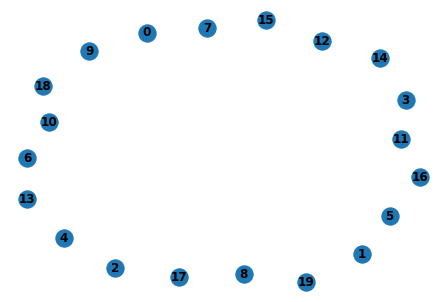

In [16]:
env = graphRLnx(network_size=20, edge_prob=0.1)
env.render()